# __Project Title__
<br>

# Setup

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import re

In [75]:
# read data
ets = pd.read_csv('ETS_Database_v49_Jul22.csv', sep='\t')
ets.head()

,country,country_code,ETS information,main activity sector name,unit,value,year
0,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,498797.0,2005
1,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,383157.0,2013
2,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,351210.0,2017
3,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,335835.0,2018
4,Austria,AT,1.1 Freely allocated allowances,32 Manufacture of ceramics,tonne of CO2 equ.,299741.0,2021


<br><br>
# Read and clean data

### Rename columns

In [76]:
ets.rename(columns={'ETS information':'category', 'main activity sector name':'sector'}, inplace=True)

<br>

### Check for unwanted data and delete

In [77]:
# establish list of rows to drop and handler function
rows_to_drop = {}
def add_rows_to_drop(colname, *rowvalues):
    if not colname in rows_to_drop: rows_to_drop[colname] = []
    rows_to_drop[colname].extend(rowvalues)

<br><br>

In [78]:
# check country column
countries = ets[['country','country_code']].drop_duplicates()
display(countries)

,country,country_code
0,Austria,AT
68,Belgium,BE
125,Bulgaria,BG
185,Cyprus,CY
220,Czechia,CZ
254,Germany,DE
367,Denmark,DK
395,Estonia,EE
423,Spain,ES
544,France,FR


In [79]:
add_rows_to_drop('country', 'NER 300 auctions') # remove unwanted auction data

<br><br>

In [80]:
# check category column
categories = ets['category'].unique()
categories.sort(); display(categories)

array(['1. Total allocated allowances (EUA or EUAA)',
       '1.1 Freely allocated allowances',
       '1.1.1 Free allocation to existing entities (Art. 10a(1))',
       '1.1.2 Free allocation from the new entrants reserve (Art. 10a(7))',
       '1.1.3 Free allocation for modernisation of electricity generation (Art. 10c)',
       '1.1.4 Swiss Free Allocated allowances for aircraft operators',
       '1.2 Correction to freely allocated allowances (not reflected in EUTL)',
       '1.3 Allowances auctioned or sold (EUAs and EUAAs)',
       '2. Verified emissions', '2.1 EU-ETS Verified Emission',
       '2.2 Swiss Verified Emissions for aircraft operators',
       '3. Estimate to reflect current ETS scope for allowances and emissions',
       '4. Total surrendered units',
       '4.1 Surrendered EU allowances (EUAs and EUAAs)',
       '4.2 Surrendered certified emission reductions (CERs)',
       '4.3 Surrendered emission reduction units (ERUs)',
       '4.4 Surrendered Units CHU/CHUAA'],

In [81]:
# over-engineer a function to identify super categories
def gather_super_categories(categories):
    found = []
    num_stop_start = '^[0-9\.]+'
    num_maybe_stop_end = '\.?[0-9]\.?$'

    for category in categories:
        num_id = re.search(num_stop_start, category).group() # get identifying numbers at start of string
        super_category = num_id[:re.search(num_maybe_stop_end, num_id).start()] # keep all but last number (and stops if present)   1.1.2. -> 1.1
        if super_category and super_category not in found: found.append(super_category)

    found = [f+'.' if len(f)==1 else f for f in found] # handle inconsistent point formatting
    filter = pd.Series(categories).str.startswith(tuple([f+' ' for f in found])) 
    return categories[filter]

In [82]:
add_rows_to_drop('category', *gather_super_categories(categories))

<br><br>

In [83]:
# check sector column
sectors = ets['sector'].unique()
sectors.sort(); display(sectors)

array(['10 Aviation', '20 Combustion of fuels',
       '20-99 All stationary installations',
       '21  Refining of mineral oil',
       '21-99 All industrial installations (excl. combustion)',
       '22  Production of coke', '23 Metal ore roasting or sintering',
       '24  Production of pig iron or steel',
       '25 Production or processing of ferrous metals',
       '26 Production of primary aluminium',
       '27 Production of secondary aluminium',
       '28 Production or processing of non-ferrous metals',
       '29 Production of cement clinker',
       '30 Production of lime, or calcination of dolomite/magnesite',
       '31 Manufacture of glass', '32 Manufacture of ceramics',
       '33 Manufacture of mineral wool',
       '34 Production or processing of gypsum or plasterboard',
       '35 Production of pulp', '36 Production of paper or cardboard',
       '37 Production of carbon black', '38 Production of nitric acid',
       '39 Production of adipic acid',
       '40 Produc

In [84]:
add_rows_to_drop('sector', '21-99 All industrial installations (excl. combustion)', '20-99 All stationary installations')

In [85]:
# fix inconsistent naming
def remove_double_spaces(s): return s.replace('  ', ' ')
ets['sector'] = ets['sector'].apply(remove_double_spaces)

<br><br>

In [86]:
# check unit column
units = ets['unit'].unique()
display(units)

array(['tonne of CO2 equ.'], dtype=object)

In [87]:
del ets['unit']

<br><br>

In [88]:
# check year column
year = ets['year'].unique()
display(year)

array(['2005', '2013', '2017', '2018', '2021', '2022', '2011', '2012',
       '2016', '2020', '2007', '2008', '2006', '2009', '2015', '2014',
       '2019', '2010', 'Total 1st trading period (05-07)',
       'Total 2nd trading period (08-12)',
       'Total 4th trading period (21-30)',
       'Total 3rd trading period (13-20)'], dtype=object)

In [89]:
add_rows_to_drop('year', 'Total 1st trading period (05-07)', 'Total 2nd trading period (08-12)', 'Total 3rd trading period (13-20)', 'Total 4th trading period (21-30)')

<br><br>

In [94]:
# perform row drop and reset index
for colname, values in rows_to_drop.items(): ets.drop(ets.loc[ets[colname].isin(values)].index, inplace=True)
ets = ets.reset_index(drop=True)

,country,country_code,category,sector,value,year
0,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,481340.0,2011
1,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,478462.0,2012
2,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2017
3,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2018
4,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2021
...,...,...,...,...,...,...
33049,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,217488.0,2016
33050,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,222518.0,2019
33051,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2011
33052,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2012


In [91]:
# format year type
ets['year'] = ets['year'].astype('int')

<br><br>

In [95]:
# resulting dataframe
display(ets)

,country,country_code,category,sector,value,year
6,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,481340.0,2011
7,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,478462.0,2012
8,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2017
9,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2018
10,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2021
...,...,...,...,...,...,...
74915,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,217488.0,2016
74916,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,222518.0,2019
74919,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2011
74920,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2012


<br><br>
# Seperate data

In [20]:
# seperate copies to prevent unintended effects
allocations = ets.copy().loc[ets['category'].str.startswith('1.')]
emissions = ets.copy().loc[ets['category'].str.startswith('2.')]
surrendered = ets.copy().loc[ets['category'].str.startswith('4.')]

<br><br>

# Describing Data

<br>

### Emissions by sector

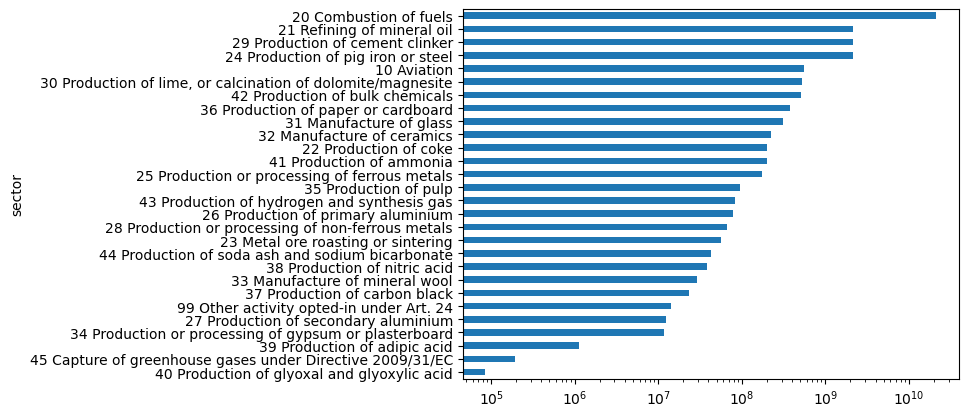

In [73]:
emissions_by_sector = emissions.groupby('sector')['value'].apply('sum')
_ = emissions_by_sector.sort_values(inplace=True)
_ = emissions_by_sector.plot(kind='barh', logx=True)

<br>

### Emissions by sector over time

In [60]:
def group_sectors(sector):
    if sector in ['20 Combustion of fuels',
                 '21 Refining of mineral oil',
                 '29 Production of cement clinker',
                 '24 Production of pig iron or steel',
                 '10 Aviation']: return sector
    else: return 'Other'

In [61]:
def group_year_sector(idx):
    year, sector = emissions['year'][idx], emissions['sector'][idx]
    sector_grp = group_sectors(sector)
    return year, sector_grp

In [62]:
EU27 = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
UK = ['United Kingdom (excl. NI)', 'Northern Ireland']
EU27_UK = EU27 + UK

In [63]:
# keep only data for countries in EU27+UK
emissions_eu = emissions.loc[emissions['country'].isin(EU27_UK)]

# for now, this is fine
sector_groups = emissions_eu.groupby(group_year_sector)['value'].apply('sum')
data = {
    'year':[],
    'sector':[],
    'value':[]
}
for idx, value in zip(sector_groups.index, sector_groups):
    year, sector = idx[0], idx[1]
    data['year'].append(year)
    data['sector'].append(sector)
    data['value'].append(value)

em = pd.DataFrame(data)

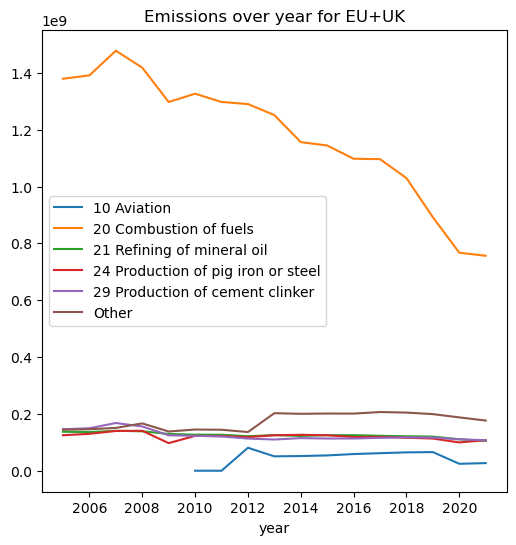

In [71]:
# emissions_sector_over_time = sector_groups.groupby(['year','sector'])['value'].apply('sum')
fig, ax = plt.subplots(figsize=(6,6))
ax.set(title = 'Emissions over year for EU+UK')
for sector, group in em.groupby('sector'):
    group.reset_index().plot(ax=ax, x='year', y='value', label=sector)

In [36]:

# group and aggregate data by year, sector, and info
emissions_eu = emissions_eu.groupby(['year', 'sector']).agg({'value': 'sum'}).reset_index()

display(emissions_eu.loc[emissions_eu['year']==2018])

,year,sector,value
341,2018,10 Aviation,6.464005e+07
342,2018,20 Combustion of fuels,1.029805e+09
343,2018,21 Refining of mineral oil,1.212397e+08
344,2018,22 Production of coke,1.109687e+07
345,2018,23 Metal ore roasting or sintering,2.660547e+06
346,2018,24 Production of pig iron or steel,1.161525e+08
347,2018,25 Production or processing of ferrous metals,1.097312e+07
348,2018,26 Production of primary aluminium,5.222089e+06
349,2018,27 Production of secondary aluminium,1.287454e+06
350,2018,28 Production or processing of non-ferrous metals,7.045423e+06


64640050.0
